## Imports

In [1]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import pandas as pd
import operator
import sys, argparse
import nltk
import math
from scipy.stats import norm
from scipy import sparse
import re
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pandas import option_context
import seaborn as sns
import os
from nltk.corpus import wordnet as wn

# Define the filenames and URLs of the dictionaries
afinn_filename = "AFINN-111.txt"
afinn_url = "https://github.com/fnielsen/afinn/raw/master/afinn/data/AFINN-111.txt"
emolex_filename = "emolex_words.csv"
emolex_url = "https://raw.githubusercontent.com/dinbav/LeXmo/master/emolex_words.csv"
vneg_b2_filename = "VERY-NEG B=2.csv"
vneg_b2_url = "https://raw.githubusercontent.com/citiususc/VERY-NEG-and-VERY-POS-Lexicons/master/VERY-NEG%20B%3D2.csv"
vneg_b1_filename = "VERY-NEG B=1.csv"
vneg_b1_url = "https://raw.githubusercontent.com/citiususc/VERY-NEG-and-VERY-POS-Lexicons/master/VERY-NEG%20B%3D1.csv"

# Check if each file already exists, and download it if not
if not os.path.isfile(afinn_filename):
    !wget -q $afinn_url
    
if not os.path.isfile(emolex_filename):
    !wget -q $emolex_url
    
if not os.path.isfile(vneg_b2_filename):
    !wget -q $vneg_b2_url
    
if not os.path.isfile(vneg_b1_filename):
    !wget -q $vneg_b1_url

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [2]:
afinn = pd.read_csv('AFINN-111.txt', sep="\t", header = None);
afinn = afinn.set_index(0)[1].to_dict(); # https://stackoverflow.com/questions/26716616/convert-a-pandas-dataframe-to-a-dictionary

emolex = pd.read_csv('emolex_words.csv');
emolex = emolex.dropna(axis=0);
emolex.index = np.arange(0, len(emolex));
emolex['sum'] = emolex.sum(axis = 1).astype(int);

veryneg1 = pd.read_csv('VERY-NEG B=1.csv');
veryneg2 = pd.read_csv('VERY-NEG B=2.csv');
veryneg = pd.concat([veryneg1, veryneg2], ignore_index=True);
veryneg = veryneg[['W', 'D(x)']].rename(columns={'W': 'word', 'D(x)': 'score'});
veryneg = veryneg.drop(veryneg[veryneg['score']>=0].index).set_index('word');
verynegdict = veryneg.to_dict()['score'];

/tmp/ipykernel_319/1725181504.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  emolex['sum'] = emolex.sum(axis = 1).astype(int);


## Data Preparation 

In [3]:
adjudicated = pd.read_table('adjudicated.tsv')
df = pd.DataFrame(adjudicated)

Randomly divide adjudicated data into training (60%), development (20%) and test (20%) splits with no overlap between them.  (If you've annotated 500 data points, you should have 300 in training, 100 in development and 100 in test.)  Put this in a folder named "splits" as "train.txt", "dev.txt" and "test.txt".

In [4]:
randomized = df.sample(n=len(df), replace=False, random_state=101).reset_index(drop=True)
train = randomized[:300]
dev = randomized[300:400]
test = randomized[400:]

In [5]:
# create directory for the splits
if not os.path.exists('splits'):
    os.makedirs('splits')
    
# Convert to txt files
train.to_csv('splits/train.txt', sep='\t', header=False ,index=False)
dev.to_csv('splits/dev.txt', sep='\t', header=False ,index=False)
test.to_csv('splits/test.txt', sep='\t', header=False ,index=False)

# Part A. Build a predictive model


## Ordinal Regression Classifier 

In [6]:
def load_ordinal_data(filename, ordering):
    X = []
    Y = []
    orig_Y=[]
    for ordinal in ordering:
        Y.append([])
        
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)
            
            index=ordering.index(label)
            for i in range(len(ordering)):
                if index > i:
                    Y[i].append(1)
                else:
                    Y[i].append(0)
            orig_Y.append(label)
                    
    return X, Y, orig_Y


In [7]:
class OrdinalClassifier:

    def __init__(self, ordinal_values, feature_method, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY):
        self.ordinal_values=ordinal_values
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_regs = [None]* (len(self.ordinal_values)-1)

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.orig_trainY=orig_trainY
        self.orig_devY=orig_devY
        self.orig_testY=orig_testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    def train(self):
        (D,F) = self.trainX.shape

  
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            best_dev_accuracy=0
            best_model=None
            for C in [0.1, 1, 10, 100]:

                log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
                log_reg.fit(self.trainX, self.trainY[idx])
                development_accuracy = log_reg.score(self.devX, self.devY[idx])
                if development_accuracy > best_dev_accuracy:
                    best_dev_accuracy=development_accuracy
                    best_model=log_reg


            self.log_regs[idx]=best_model
        
    def test(self):
        cor=tot=0
        counts=Counter()
        preds=[None]*(len(self.ordinal_values)-1)
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            preds[idx]=self.log_regs[idx].predict_proba(self.testX)[:,1]
        
        preds=np.array(preds)
        pred_label = []
            
        for data_point in range(len(preds[0])):
            
    
            ordinal_preds=np.zeros(len(self.ordinal_values))
            for ordinal in range(len(self.ordinal_values)-1):
                if ordinal == 0:
                    ordinal_preds[ordinal]=1-preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal]=preds[ordinal-1][data_point]-preds[ordinal][data_point]

            ordinal_preds[len(self.ordinal_values)-1]=preds[len(preds)-1][data_point]

            prediction=np.argmax(ordinal_preds)
            pred_label.append(prediction+1)
            counts[prediction]+=1
            if prediction == self.ordinal_values.index(self.orig_testY[data_point]):
                cor+=1
            tot+=1
        return cor/tot, np.array(pred_label)

    def printWeights_list(self, n=10):
        reverse_vocab=[None]*len(self.log_regs[0].coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            weights = self.log_regs[idx].coef_[0]

            print("Label %d:" % (idx+1))
            for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                print("%.3f\t%s" % (weight, feature))
            print()


    def printWeights(self, n=10):
        reverse_vocab = [None] * len(self.log_regs[0].coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]] = k
        
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            weights = self.log_regs[idx].coef_[0]
            sorted_weights = sorted(zip(reverse_vocab, weights), key=operator.itemgetter(1))

            top_features = list(reversed([x[0] for x in sorted_weights[-n:]]))
            top_weights = list(reversed([x[1] for x in sorted_weights[-n:]]))

            row, col = idx // 2, idx % 2
            sns.barplot(x=top_weights, y=top_features, ax=axes[row, col])
            axes[row, col].set_title(f"Fig.3{chr(ord('a')+idx)} Label {idx+1}")
            axes[row, col].set_xlabel("Weight")
            axes[row, col].set_ylabel("Feature")
        
        plt.tight_layout()
        plt.show()


## Features Implementation

In [8]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[f"bow_{word}"]=1
            
    return feats

### Feature 1: Punctuation, Filler Words, and Capitalization

In [9]:
def syntax_featurize(text):

    feats = {}
    words = nltk.word_tokenize(text)

    word_count = 0
    excl_count = 0
    ques_count = 0
    paren_count = 0
    ellip_count = 0

    for word in words: 
        if word == "!":
            excl_count += 1
        elif word == "?":
            ques_count += 1
        elif word == "(":
            paren_count += 1
        elif re.search("\.{2,}", word):
            ellip_count += 1
        word_count += 1

    punc_value = (excl_count + ques_count + paren_count + ellip_count) / word_count
    feats['punctuation'] = punc_value
    return feats

In [10]:
def filler_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    filler_count = 0
    word_count = 0

    for word in words:
        if word in ['plus', 'to top that off', 'honestly', 'for sure', 'and then', 'finally', 'so', 'i mean', 'like', 'sort of']:
            filler_count += 1
        word_count += 1
    
    feats['fillers'] = filler_count / word_count
    return feats

In [11]:
def punctuation_featureize(text):
    feats = {}
    puncs = re.findall("[^\w\s]+", text) # https://docs.python.org/3/library/re.html
    for punc in puncs:
        if punc in ['!',"?", "...", "......", "..", "!!", "!!!", "??", "???"]: # use regex?
            feats[punc] = 2     
    return feats

In [12]:
# a feature to detect usage of words that are fully capitalized
def capitalization_featurize(text):
    
    feats = {}
    words = nltk.word_tokenize(text)
    cap_count = 0
    word_count = 0

    for word in words:
        if re.search("[A-Z]", word):
            cap_count += 1
        word_count += 1
    
    feats['capitalized'] = cap_count / word_count
    return feats

### Feature 2 Rhetorical Devices

In [13]:
stopwords = nltk.corpus.stopwords.words("english")

In [14]:
def epistrophe_featurize(text):

    """ Captures instances of epistrophe in a post"""
    feats = {}
    words = nltk.word_tokenize(text)
    seen_words = {}

    for word in words:
        word = word.lower()
        if word in stopwords or not word.isalpha():
            continue
        seen_words[word] = seen_words.get(word, 0) + 1
        if seen_words[word] >= 3:
            feats["epistrophe"] = True
    return feats

In [15]:
def metaphor_featurize(text):

    """ Captures instances of metaphors in a post"""
    feats = {}
    ngrams = nltk.ngrams(nltk.word_tokenize(text), n=3)
    metaphor_pattern = re.compile(r"(\w+ (?:is|was|feels|seems|appears to be) \w+)")

    for ngram in ngrams:
        ngram_str = " ".join(ngram).lower()
        if metaphor_pattern.search(ngram_str):
            feats[f"metaphor_{ngram_str}"] = True
    return feats

### Feature 3 Dictionaries

In [16]:
def bigram_featurize(text):
    feats = {}
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    bigrm = list(nltk.bigrams(text.split())) # from https://stackoverflow.com/questions/37651057/generate-bigrams-with-nltk
    bigrm_str = [' '.join(t) for t in bigrm]
    for b in bigrm_str:
        feats[b] = 1      
    return feats

In [17]:
def dictionary_featurize(text):
     
    feats = {}
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = nltk.word_tokenize(text)
    count = dict(Counter(words))

    feats["EMOLEX num neutral words"] = 0
    feats["EMOLEX num emotional words"] = 0
    
    for word in words:
        if word in afinn:
            score = afinn[word]
            feats["AFINN score of " + word] = abs(score)
            if abs(score) >= 2:
                feats["AFINN count of " + word] = count[word]
                
        if word in np.array(emolex['word']):
            sum = (emolex[emolex['word'] == word])['sum'].values[0]
            feats["EMOLEX num emotions of " + word] = sum
            if sum == 0:
                feats["EMOLEX num neutral words"] += 1
            else: 
                feats["EMOLEX num emotional words"] +=1

        if word in verynegdict:
            feats["VERYNEG has neg"] = 1
            
    return feats

In [18]:
def melodramatic_featurize(text):
    melodramatic_adjectives = ['crazy', 'tragic', 'heartbreaking', 'devastating', 'shocking', 'outrageous', 'horrifying', 'worthless', 'useless', 'devastate', 'worst', 'hopelessness', 'intense', 'hell', 'lying', 'depressed', 'screaming']
    feats = {}
    words = nltk.word_tokenize(text)
    melodramatic_count = 0
    melodramatic_words = []
    
    for word in words:
        for synset in wn.synsets(word):
            for adjective in melodramatic_adjectives:
                if synset.name().split('.')[0] == adjective or word == adjective:
                    melodramatic_words.append(adjective)
    
    for adjective in melodramatic_adjectives:
        feats['melodramatic_'+adjective] = melodramatic_words.count(adjective)

    return feats

## Combiner Function

In [19]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [20]:
def combiner_function(text):
    all_feats={}
    for feature in [binary_bow_featurize, punctuation_featureize, epistrophe_featurize, bigram_featurize, dictionary_featurize, melodramatic_featurize, syntax_featurize, filler_featurize, capitalization_featurize]:
        all_feats.update(feature(text))
    return all_feats

In [21]:
trainingFile = "splits/train.txt"
devFile = "splits/dev.txt"
testFile = "splits/test.txt"

ordinal_values=["1", "2", "3", "4", "5"]

trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)

big_classifier = OrdinalClassifier(ordinal_values, combiner_function, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
big_classifier.train()
accuracy, pred_label = big_classifier.test()
true_label = np.array(orig_testY).astype(int)

lower, upper=confidence_intervals(accuracy, len(testY[0]), .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.610, 95% CIs: [0.514 0.706]



# Part B. Analysis


## Visualizations

In [22]:
# count and display proportions of both true and predicted labels
def label_proportions(labels):
    counter = Counter(labels)
    proportions = {}
    total = sum(counter.values())
    for label, count in counter.items():
        proportions[label] = count / total
    return proportions

true_labels_prop = label_proportions(orig_testY)
pred_labels_prop = label_proportions(pred_label)
pred_labels_prop[5] = 0
label_diffs = {1: 0.03, 2: 0.05, 3: 0.02, 4: 0.03, 5: 0.01}

print("True Label Proportions:")
for key, value in sorted(true_labels_prop.items()):
    print(f'{key}: {"{:.2f}%".format(value * 100)}')

print("\nPredicted Label Proportions:")
for key, value in sorted(pred_labels_prop.items()):
    print(f'{key}: {"{:.2f}%".format(value * 100)}')

print("\nTrue and Predicted Label Proportion Differences:")
for key, value in sorted(label_diffs.items()):
    print(f'{key}: {"{:.2f}%".format(value * 100)}')


True Label Proportions:
1: 29.00%
2: 39.00%
3: 25.00%
4: 6.00%
5: 1.00%

Predicted Label Proportions:
1: 26.00%
2: 44.00%
3: 27.00%
4: 3.00%
5: 0.00%

True and Predicted Label Proportion Differences:
1: 3.00%
2: 5.00%
3: 2.00%
4: 3.00%
5: 1.00%


### Proportionality of True and Predicted Labels (Fig.1a & 1b)

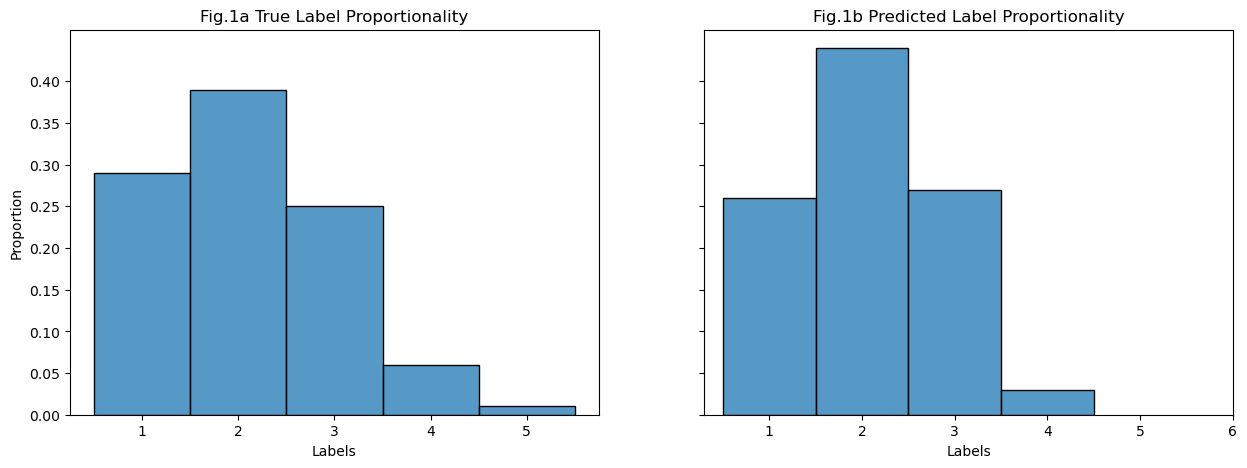

In [23]:
f, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row')
hist1 = sns.histplot(sorted(orig_testY), stat='proportion', ax = axes[0])
hist2 = sns.histplot(sorted(pred_label), stat='proportion', discrete=True, ax = axes[1])
axes[0].set_title('Fig.1a True Label Proportionality')
axes[1].set_title('Fig.1b Predicted Label Proportionality')
hist1.set_xlabel('Labels')
hist2.set_xlabel('Labels')
plt.xticks(np.arange(1, 6.5))
plt.yticks(np.arange(0, 0.45, 0.05))
plt.show()

### Confusion Matrix (Fig.2a & 2b)

Text(0.5, 1.0, 'Fig.2b Unnormalized Confusion Matrix')

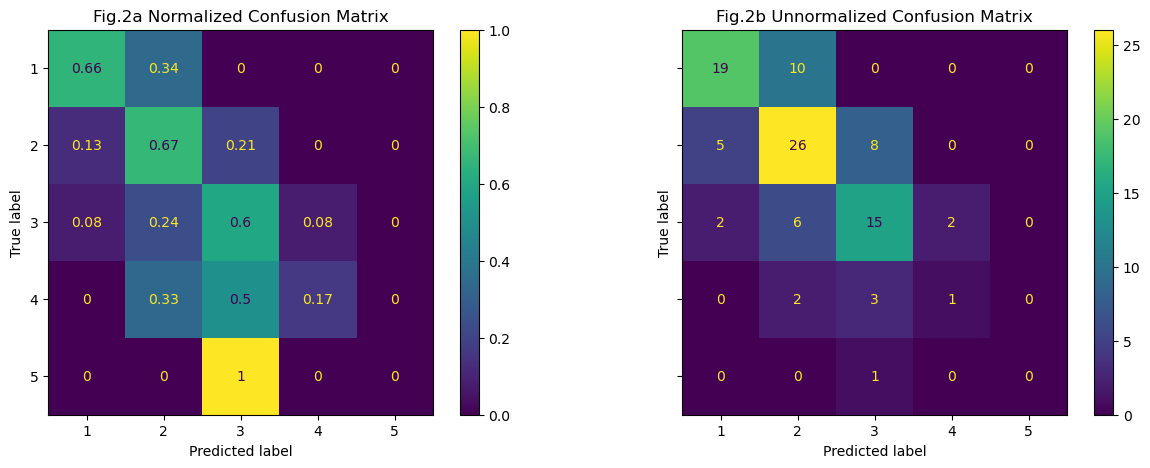

In [24]:
f, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row')
cm1 = ConfusionMatrixDisplay.from_predictions(true_label, pred_label, normalize = 'true', ax = axes[0])
cm2 = ConfusionMatrixDisplay.from_predictions(true_label, pred_label, normalize = None, ax = axes[1])
axes[0].set_title('Fig.2a Normalized Confusion Matrix')
axes[1].set_title('Fig.2b Unnormalized Confusion Matrix')

### Top Features (Fig.3a-d)

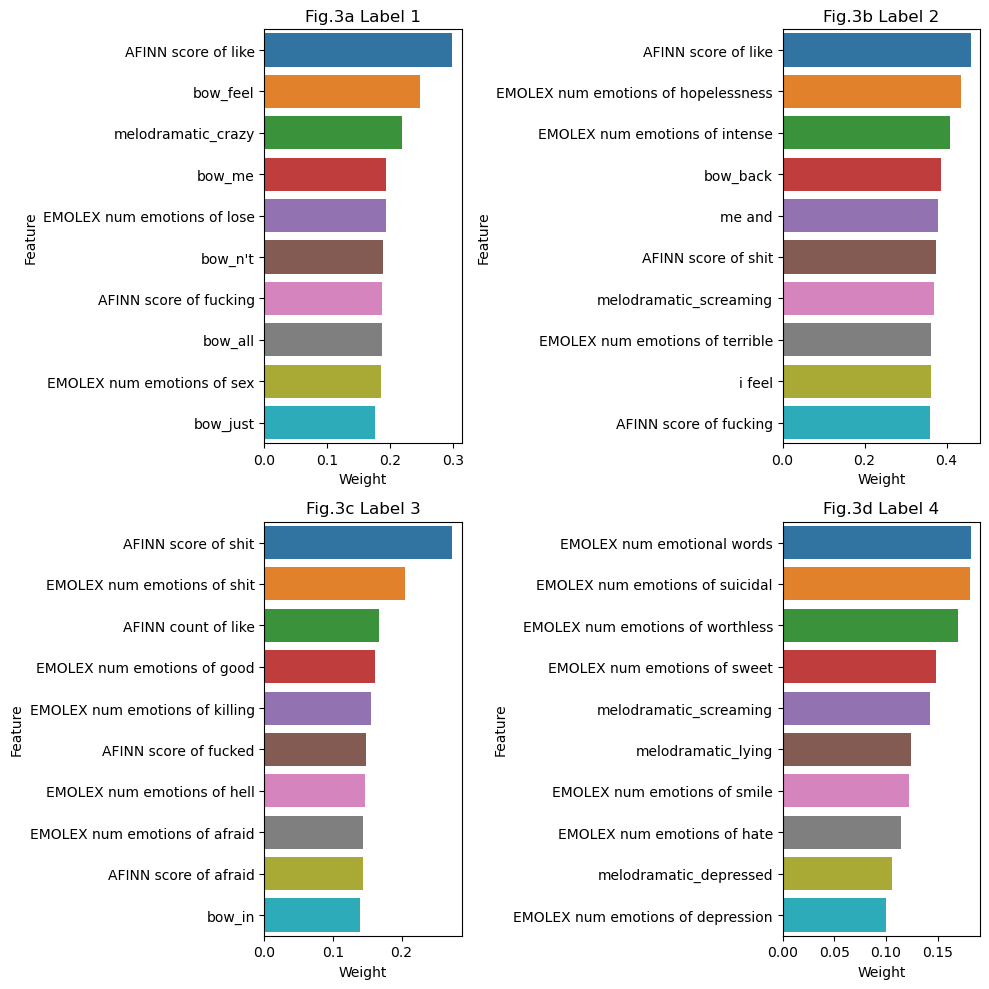

In [25]:
big_classifier.printWeights()

## Analysis Results and Interpretation


By integrating various features into the Ordinal Regression classifier, the model yielded a test accuracy of 0.610 for the best development model, accompanied by a 95% Confidence Interval ranging from 0.514 to 0.706.


### **Overview of the dataset and model’s predictions**

Fig. 1a and 1b summarize the label proportions of the true and predicted labels. We can first see that the model's predictions of the labels follow the trends of the true labels that were manually adjudicated, namely a Gaussian distribution that skews left, which can further be observed by the difference between the proportionality for each label never surpassing 5%, i.e. there being low variance. Label 2 is the most prevalent, comprising 39% of the adjudicated data and 44% of the model's predictions, and Label 5 is the least prevalent, comprising 1% of the adjudicated data and 0% of the model's predictions. 

### **Accuracy of the model's predictions for each label**

According to Fig. 2a, around 60% of all of Labels 1, 2, and 3 were accurately predicted; however, only 17% of Label 4 was accurately predicted and none of Label 5 was accurately predicted. For label 4, 50% were predicted as 3, and 33% were predicted as 2; for label 5, all were predicted as 3. 

As observed in Fig. 2a and 2b, the most easily mistaken pairs of labels are Labels 3 & 5,  Labels 1 & 2, Labels 3 & 4, and Labels 2 and 4. And we can see that the classifier never classifies any document to be Label 5.

### **Top features for each label**

Based on the top 10 features for each label, there are some similarities and differences among the labels. Firstly, we can see that certain features are consistently important across all labels, such as the AFINN scores or counts of “like” and “shit.” (Fig.3) This suggests that the overall sentiment of the post has a significant impact on how melodramatic a post is perceived to be.

Our model relies on a blend of sentiment and emotional analysis to predict the labels. Labels 1 and 2, in particular, seem to focus on overall sentiment and negative emotions (Fig.3a & b). On the other hand, Labels 3 and 4 highlight more extreme and intense words (Fig.4a & b). It's worth noting that Label 5 was excluded from this analysis due to its scarcity in the data. Due to randomization, only one document with a true rating of 5 exists in the test set, and there were only nine instances of Label 5 throughout the entire adjudicated data of 500 data points.

#### **Other features affecting model performance:**

Interestingly, features related to syntax and punctuation did not play a significant role in predicting the labels (improved accuracy only by 2%). Additionally, our model did not heavily rely on features that attempt to capture rhetorical devices, which could be because it's tough to accurately capture those types of devices from text. Instead, the model relied on more straightforward features such as word frequency and sentiment scores. Overall, our model mainly relies on sentiment analysis and incorporates emotional analysis to predict the labels.


### **Areas for Further Research/Improvement**

#### **Imbalanced dataset and potential solutions**

Unfortunately, the current dataset lacks sufficient data for Labels 4 and 5, impeding the model’s training. Therefore, this dataset would be a good candidate for oversampling and undersampling, namely duplicating examples from the Label 5 class and removing examples from the Label 2 class. Moreover, we could apply weights to penalize the Label 2 class’s prevalence.

Furthermore, to enhance the model’s performance, we could select data from a wider range of subreddits so that ideally, the proportion of data points is evenly distributed under each label. It's also essential to reassess the necessity of low-prevalence labels and consider combining labels with similar features. For instance, combining Label 5 with Label 4 could be a viable alternative.


#### **General improvements**

In terms of improving the accuracy of Label 4, which is currently at 17% (Fig.2a), it may be beneficial to incorporate more refined or nuanced emotional features such as “hopelessness,” “worthlessness,” and “suicidal.” According to Fig.3d, these features could help the model better distinguish between the different levels of melodramaticism expressed in posts rated 4 and 3. 

To address the issue of misclassification between Label 2 and Label 3, where approximately 20% of each label is inaccurately categorized as the other (Fig.2a). According to Fig.3b and 3c, we observed different levels of profanity usage between the two labels. Therefore, one possible solution is to incorporate a feature related to profanity to improve the model’s ability to accurately differentiate between the two labels.

Additionally, incorporating features related to the personal tone of the post, such as the use of first-person pronouns or personal experiences, and intensifiers, such as  “absolutely”, “surely”, and “totally”, could also be helpful in general.

In conclusion, melodramaticism can be measured in a multitude of ways, each of which affects the tone, syntax, and overall language of the user’s post. One must exercise caution when reading and believing stories online.